# Density Estimation: Gaussian Mixture Models

Here we'll explore **Gaussian Mixture Models**, which is an ***unsupervised clustering & density estimation technique.***

We'll start with our standard set of initial imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

import warnings
warnings.filterwarnings('ignore')

## Introducing Gaussian Mixture Models

We previously saw an example of K-Means, which is a clustering algorithm which is most often fit using an expectation-maximization approach.

Here we'll consider an extension to this which is suitable for both **clustering** and **density estimation**.

For example, imagine we have some one-dimensional data in a particular distribution:

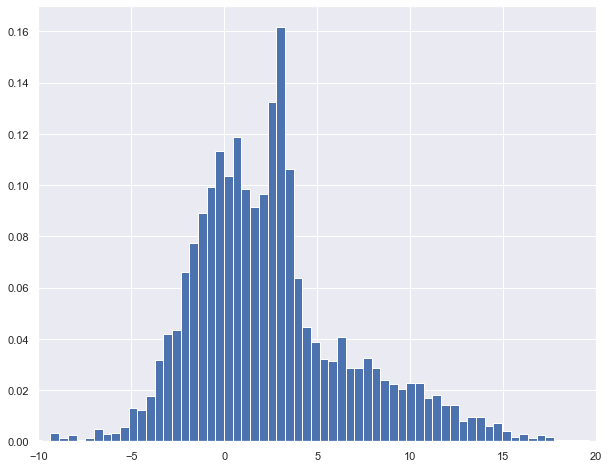

In [3]:
np.random.seed(2)
x = np.concatenate([np.random.normal(0, 2, 2000),
                    np.random.normal(5, 5, 2000),
                    np.random.normal(3, 0.5, 600)])
plt.figure(figsize=(10,8))
plt.hist(x, 80, density=True)
plt.xlim(-10, 20);

Gaussian mixture models will allow us to approximate this density:

In [4]:
from sklearn.mixture import GaussianMixture as GMM
X = x[:, np.newaxis]
clf = GMM(4, max_iter=500, random_state=3).fit(X)

In [5]:
xpdf = np.linspace(-10, 20, 1000)
density = np.array([np.exp(clf.score([[xp]])) for xp in xpdf])

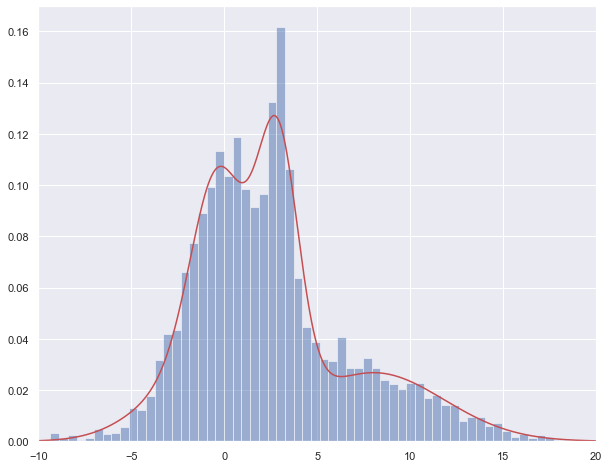

In [6]:
plt.figure(figsize=(10,8))
plt.hist(x, 80, density=True, alpha=0.5)
plt.plot(xpdf, density, '-r')
plt.xlim(-10, 20);

Note that this density is fit using a **mixture of Gaussians**, which we can examine by looking at the ``means_``, ``covars_``, and ``weights_`` attributes:

In [7]:
clf.means_

array([[-1.762037  ],
       [ 8.04894855],
       [ 2.87628921],
       [-0.26509542]])

In [8]:
clf.covariances_

array([[[ 7.39304484]],

       [[14.2611261 ]],

       [[ 1.25253655]],

       [[ 2.1852085 ]]])

In [9]:
clf.weights_

array([0.15154409, 0.2532411 , 0.28492403, 0.31029078])

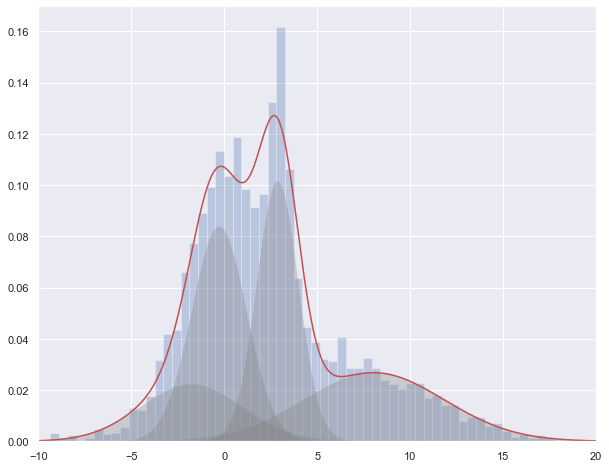

In [11]:
plt.figure(figsize=(10,8))
plt.hist(x, 80, density=True, alpha=0.3)
plt.plot(xpdf, density, '-r')

for i in range(clf.n_components):
    pdf = clf.weights_[i] * stats.norm(clf.means_[i, 0],
                                       np.sqrt(clf.covariances_[i, 0])).pdf(xpdf)
    plt.fill(xpdf, pdf, facecolor='gray',
             edgecolor='none', alpha=0.3)
plt.xlim(-10, 20);

These individual Gaussian distributions are fit using an expectation-maximization method
 - much as in K means, except that rather than explicit cluster assignment, the **posterior probability** is used to compute the weighted mean and covariance.


- Somewhat surprisingly, this algorithm **provably** converges to the optimum (though the optimum is not necessarily global).

## How many Gaussians?

Given a model, we can use one of several means to evaluate how well it fits the data.
For example, there is the Aikaki Information Criterion (AIC) and the Bayesian Information Criterion (BIC)

In [12]:
print(clf.bic(X))
print(clf.aic(X))

25825.201910224507
25754.42998281726


Let's take a look at these as a function of the number of gaussians:

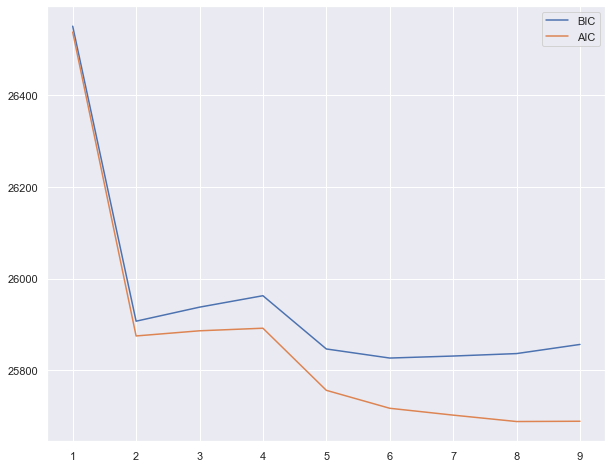

In [13]:
n_estimators = np.arange(1, 10)
clfs = [GMM(n, max_iter=1000).fit(X) for n in n_estimators]
bics = [clf.bic(X) for clf in clfs]
aics = [clf.aic(X) for clf in clfs]

plt.figure(figsize=(10,8))
plt.plot(n_estimators, bics, label='BIC')
plt.plot(n_estimators, aics, label='AIC')
plt.legend();


It appears that for both the AIC and BIC, 4 components is preferred.

## Example: GMM for Clustering

In [15]:
# Generate some data
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

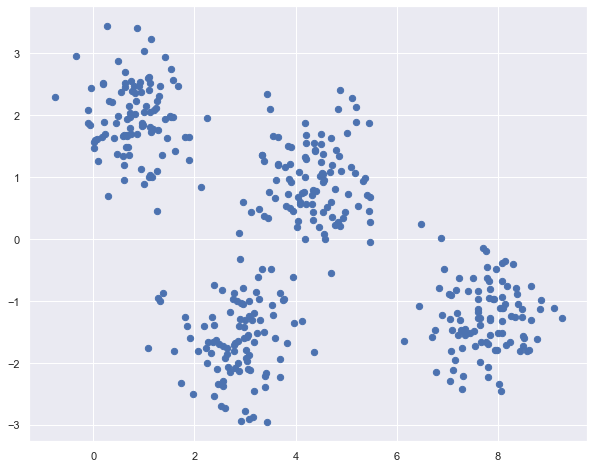

In [16]:
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], s=40)

### K-Means

In [17]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

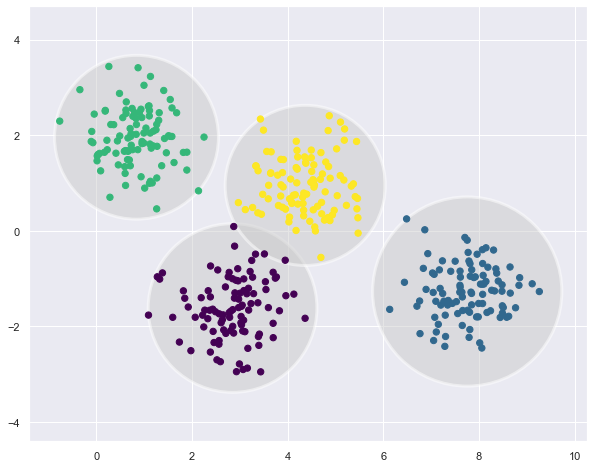

In [18]:
kmeans = KMeans(n_clusters=4, random_state=0)
plt.figure(figsize=(10,8))
plot_kmeans(kmeans, X)

An important observation for k-means is that these cluster models must be circular: k-means has no built-in way of accounting for oblong or elliptical clusters.

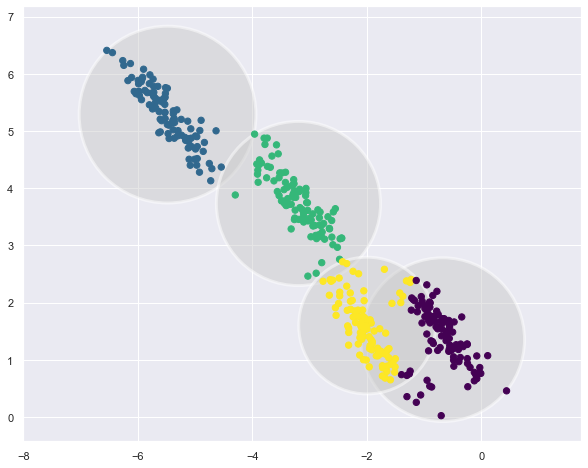

In [19]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
plt.figure(figsize=(10,8))
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

### GMM

A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means:

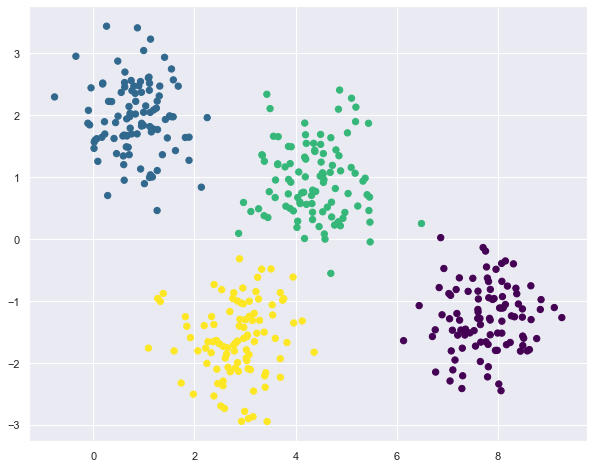

In [20]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [21]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

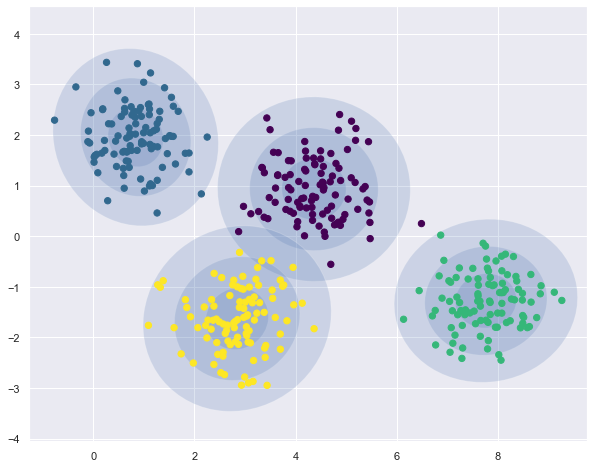

In [22]:
gmm = GMM(n_components=4, random_state=42)
plt.figure(figsize=(10,8))
plot_gmm(gmm, X)

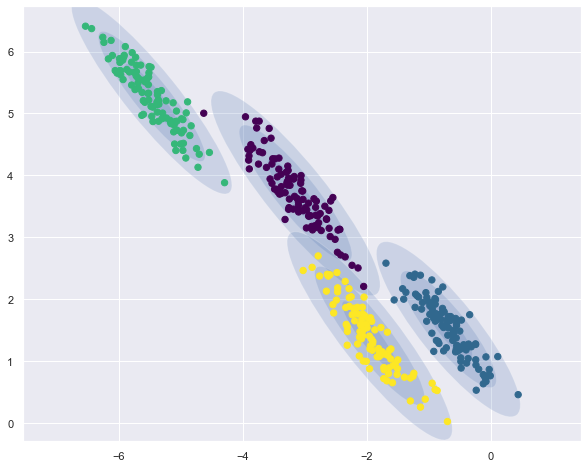

In [23]:
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plt.figure(figsize=(10,8))
plot_gmm(gmm, X_stretched)

This makes clear that GMM addresses the two main practical issues with k-means encountered before.

## Example: GMM For Outlier Detection

GMM is what's known as a **Generative Model**: it's a probabilistic model from which a dataset can be generated.

- One thing that generative models can be useful for is **outlier detection**: we can simply evaluate the likelihood of each point under the generative model
    - the points with a suitably low likelihood (where "suitable" is up to your own bias/variance preference) can be labeld outliers.

Let's take a look at this by defining a new dataset with some outliers:

In [24]:
np.random.seed(0)

# Add 20 outliers
true_outliers = np.sort(np.random.randint(0, len(x), 20))
y = x.copy()
y[true_outliers] += 50 * np.random.randn(20)

(-15.0, 30.0)

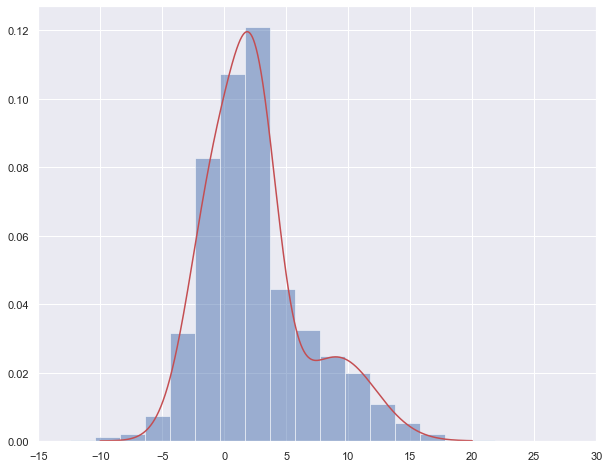

In [25]:
clf = GMM(4, max_iter=500, random_state=0).fit(y[:, np.newaxis])
xpdf = np.linspace(-10, 20, 1000)
density_noise = np.array([np.exp(clf.score([[xp]])) for xp in xpdf])

plt.figure(figsize=(10,8))
plt.hist(y, 80, density=True, alpha=0.5)
plt.plot(xpdf, density_noise, '-r')
plt.xlim(-15, 30)


Now let's evaluate the log-likelihood of each point under the model, and plot these as a function of ``y``:

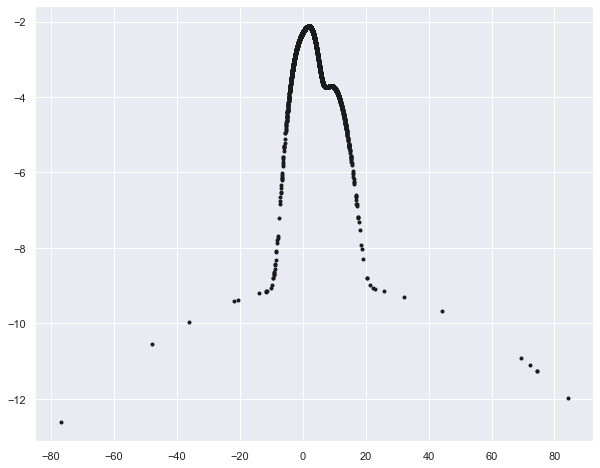

In [26]:
log_likelihood = np.array([clf.score_samples([[yy]]) for yy in y])
plt.figure(figsize=(10,8))
plt.plot(y, log_likelihood, '.k');

In [27]:
detected_outliers = np.where(log_likelihood < -9)[0]

print("true outliers:")
print(true_outliers)
print("\ndetected outliers:")
print(detected_outliers)

true outliers:
[  99  537  705 1033 1653 1701 1871 2046 2135 2163 2222 2496 2599 2607
 2732 2893 2897 3264 3468 4373]

detected outliers:
[  99  537  705 1653 2046 2130 2135 2163 2222 2496 2724 2732 2893 2897
 3067 3173 3253 3468 3483 4373]


The algorithm misses a few of these points, which is to be expected (some of the "outliers" actually land in the middle of the distribution!)

Here are the outliers that were missed:

In [28]:
set(true_outliers.flatten()) - set(detected_outliers)

{1033, 1701, 1871, 2599, 2607, 3264}

And here are the non-outliers which were spuriously labeled outliers:

In [29]:
set(detected_outliers) - set(true_outliers)

{2130, 2724, 3067, 3173, 3253, 3483}

## Other Density Estimators

The other main density estimator that you might find useful is *Kernel Density Estimation*, which is available via ``sklearn.neighbors.KernelDensity``. In some ways, this can be thought of as a generalization of GMM where there is a gaussian placed at the location of *every* training point!

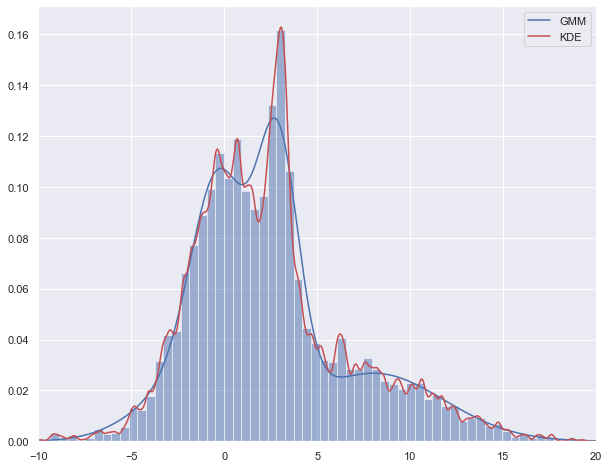

In [31]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(0.15).fit(x[:, None])
density_kde = np.exp(kde.score_samples(xpdf[:, None]))

plt.figure(figsize=(10,8))
plt.hist(x, 80, density=True, alpha=0.5)
plt.plot(xpdf, density, '-b', label='GMM')
plt.plot(xpdf, density_kde, '-r', label='KDE')
plt.xlim(-10, 20)
plt.legend();

All of these density estimators can be viewed as **Generative models** of the data: that is, that is, the model tells us how more data can be created which fits the model.

<small><i>Reference [GitHub](https://github.com/jakevdp/sklearn_pycon2015/).</i></small>